# Class 10: Clustering & Community Detection 1 — Traditional

In [1]:
%matplotlib inline
from matplotlib import pylab as plt
import seaborn as sns

In [2]:
with open('./data/top15_airports.txt') as fp:
    data = {}
    for line in fp:
        airport, latitute, longitude = line.strip().split()
        data[airport] = list(map(float, (latitute,longitude)))

In [3]:
data

{'ATL': [33.640833, -84.427222],
 'DEN': [39.765278, -104.879444],
 'DFW': [32.894444, -97.029722],
 'DTW': [42.216667, -83.344444],
 'EWR': [40.695833, -74.171667],
 'IAD': [38.941667, -77.4575],
 'IAH': [29.983333, -95.34],
 'LAX': [34.066389, -118.124444],
 'MSP': [44.886111, -93.217778],
 'ORD': [41.978056, -87.906111],
 'PHL': [39.868056, -75.248611],
 'PHX': [33.436111, -112.009444],
 'SEA': [47.447222, -122.305556],
 'SFO': [37.618889, -122.374167],
 'STL': [38.747778, -90.36]}

In [4]:
import numpy as np
def distance(lat1, long1, lat2, long2):
    degrees_to_radians = np.pi/180.0
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos( cos )
    return arc*6371.   

In [5]:
labels = list(data.keys())

In [6]:
distances = []

In [7]:
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        lat1, lon1 = data[labels[i]]
        lat2, lon2 = data[labels[j]]
        distances.append(distance(lat1,lon1,lat2,lon2))
distances = np.array(distances)

In [8]:
distances

array([ 1940.89887491,  1173.88525085,   958.281636  ,  1198.96737836,
         858.32890606,  1107.71202008,  3097.82202202,  1459.55395923,
         975.89160835,  1070.45133863,  2548.84051913,  3504.46796048,
        3434.57780408,   778.02932777,  1037.46815434,  1822.89472254,
        2595.60065262,  2350.33617427,  1391.1541771 ,  1335.20804162,
        1113.4456066 ,  1445.72813853,  2519.01881627,   948.22212332,
        1637.08576767,  1534.45575385,  1253.85308826,  1586.92907077,
        2204.1092128 ,  1881.67991291,   361.20346266,  1957.29760025,
        1373.18722053,  1290.28731947,  2091.58703517,  1394.42061381,
        2668.56482654,  2352.68292024,   885.609139  ,   782.48438792,
         616.02600109,  1731.7392984 ,  3149.27118014,   848.55869746,
         377.2597289 ,   727.08435261,  2684.49310764,  3093.23862297,
        3337.98024815,   707.32793128,   341.71824864,  2250.4429562 ,
        3911.25319998,  1618.11774758,  1154.23974152,   129.68148899,
      

Notice that distances is a "condensed distance matrix". 

A condensed distance matrix is a flat array containing the upper triangular of the distance matrix.

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [13]:
data_link = linkage(distances, method = 'single') # linkage matrix

In [16]:
data_link.astype(int)

array([[   4,   10,  129,    2],
       [   5,   15,  215,    3],
       [   2,    6,  361,    2],
       [   3,    9,  377,    2],
       [  14,   18,  414,    3],
       [   8,   19,  536,    4],
       [   7,   13,  550,    2],
       [  11,   21,  569,    3],
       [  16,   20,  616,    7],
       [   0,   23,  778,    8],
       [  17,   24,  885,   10],
       [   1,   22,  948,    4],
       [  25,   26, 1037,   14],
       [  12,   27, 1092,   15]])

In [11]:
linkage?

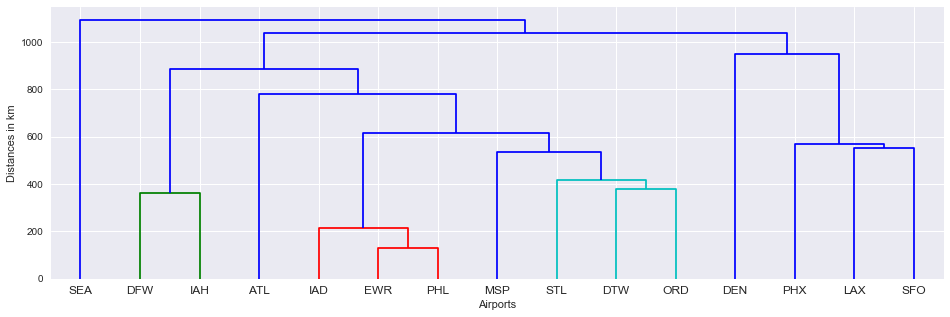

In [18]:
plt.figure(figsize=(16,5))
__=dendrogram(data_link, labels=labels, color_threshold=500)
plt.xlabel('Airports')
plt.ylabel('Distances in km')

The format of the linkage matrix is of the type:
- [idx1, idx2, dist, sample_count]

In [20]:
labels[4]

'EWR'

In [21]:
labels[10]

'PHL'

In [22]:
labels[5]

'IAD'

In [18]:
data_link.astype(int)

array([[   4,   10,  129,    2],
       [   5,   15,  215,    3],
       [   2,    6,  361,    2],
       [   3,    9,  377,    2],
       [  14,   18,  414,    3],
       [   8,   19,  536,    4],
       [   7,   13,  550,    2],
       [  11,   21,  569,    3],
       [  16,   20,  616,    7],
       [   0,   23,  778,    8],
       [  17,   24,  885,   10],
       [   1,   22,  948,    4],
       [  25,   26, 1037,   14],
       [  12,   27, 1092,   15]])

In [19]:
len(labels)

15

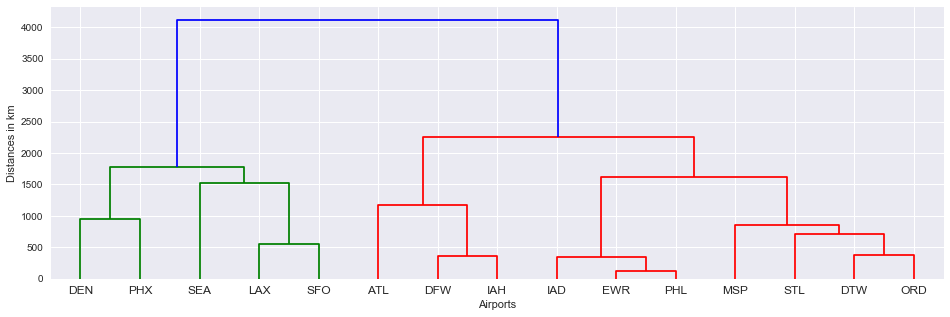

In [23]:
# Using complete linkage clustering
data_link = linkage(distances, method = 'complete')
plt.figure(figsize=(16,5))
dendrogram(data_link, labels=labels)
plt.xlabel('Airports')
plt.ylabel('Distances in km')

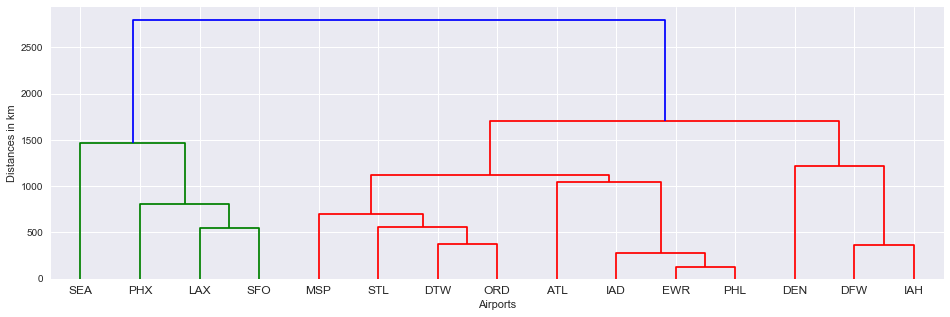

In [24]:
# Using average linkage clustering
data_link = linkage(distances, method = 'average')
plt.figure(figsize=(16,5))
dendrogram(data_link, labels=labels)
plt.xlabel('Airports')
plt.ylabel('Distances in km')

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.optimal_leaf_ordering.html

https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab

## Girvan-Newman method

The algorithm works as follow:
1. Calculate the betweenness of all edges
2. Remove the one with highest betweenness
3. Recalculate the betweenness of the remaining edges
4. Repeat from 2 until no edges remain
5. Select the partition that give the highest modularity score 

In [2]:
import networkx as nx
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [20]:
G = nx.karate_club_graph()

In [21]:
N = G.number_of_nodes()
M = G.number_of_edges()
print(N)
print(M)

34
78


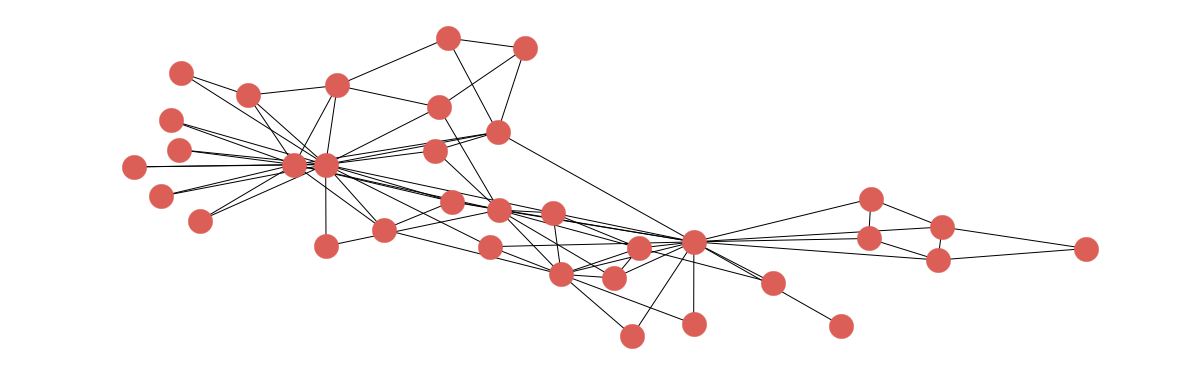

In [27]:
pos = nx.spring_layout(G, iterations=300)
plt.figure(figsize=(16,5))
color_sns = sns.color_palette('hls',1)
nx.draw(G, pos=pos, node_size=600, node_color=color_sns)

In [28]:
group_instructor = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
group_president = [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
ideal_partition = {}
for node in group_instructor:
    ideal_partition[node] = 0
for node in group_president:
    ideal_partition[node] = 1

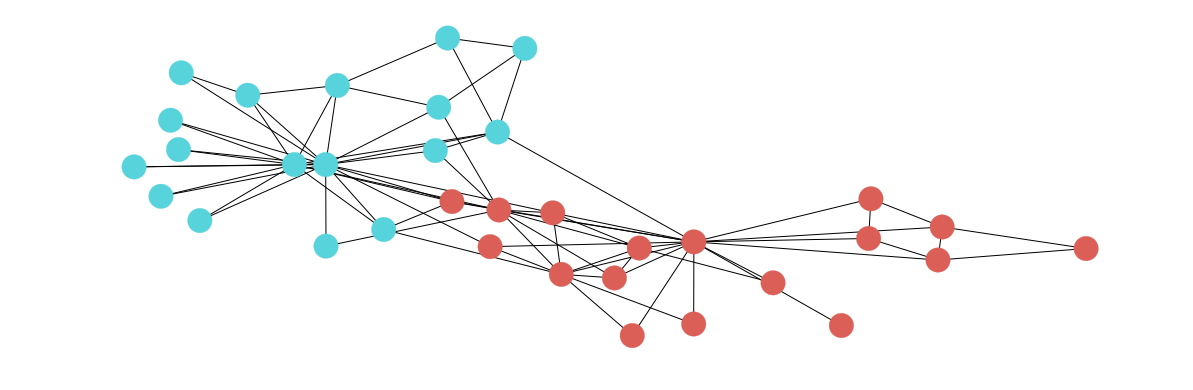

In [30]:
plt.figure(figsize=(16,5))
color_sns = sns.color_palette('hls',2)
color_nodes = [color_sns[ideal_partition[node]] for node in G.node() ]
nx.draw(G, pos=pos, node_size=600, node_color=color_nodes)

$$ Q = \sum_{\mathbb{C} \in \mathbb{P}} \left[ \frac{E_{\mathbb{C}}}{M} - \left( \frac{k_{\mathbb{C}}}{2M} \right)^2 \right] $$


where $E_{\mathbb{C}}$ denotes the total number of edges within each cluster $\mathbb{C}$ and $k_{\mathbb{C}}$ denotes the sum of the degrees of the nodes in $\mathbb{C}$.

In [31]:
from collections import defaultdict

In [3]:
def get_modularity(G,partition):
    E_c = defaultdict(float)
    k_c = defaultdict(float)
    M = G.number_of_edges()
    
    for source_node, target_node in G.edges():
        if partition[source_node] == partition[target_node]:
            E_c[partition[source_node]] += 1
            
    degrees = G.degree()
    for node in G.nodes():
        k_c[partition[node]] += degrees[node]
    
    Q = sum([ (E_c[c]/M) - (k_c[c]/(2*M))**2 for c in k_c.keys() ])
    
    return Q


In [34]:
get_modularity(G,ideal_partition)

0.3582347140039447

In [35]:
G.remove_edge?

In [36]:
def summ(x,y):
    return x+y

In [37]:
foo = (1,20)

In [38]:
summ(foo[0], foo[1])

21

In [39]:
summ(*foo)

21

In [40]:
bet = nx.edge_betweenness_centrality(G)

In [47]:
sorted(bet.items(), key = lambda x:x[1])[-1][0]

(0, 31)

In [48]:
sorted(bet.items(), key = lambda x:x[1], reverse=True)[0][0]

(0, 31)

In [41]:
bet

{(0, 1): 0.025252525252525245,
 (0, 2): 0.0777876807288572,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.04237189825425121,
 (0, 17): 0.04012392835922248,
 (0, 19): 0.045936960642843,
 (0, 21): 0.040123928359222474,
 (0, 31): 0.1272599949070537,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.01869960105254222,
 (1, 19): 0.014633732280791102,
 (1, 21): 0.01869960105254222,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384543,
 (3, 7): 0.00336558

In [52]:
def girvan_newman(G):
    Q_max = -1.0
    H = G.copy()
    
    partition = {node:0 for node in G.nodes()}
    best_partition = partition.copy()
    
    while H.number_of_edges() > 0:
        edges_bet = nx.edge_betweenness_centrality(H)
        edge2remove = sorted(edges_bet.items(), key = lambda x:x[1], reverse=True)[0][0]
        H.remove_edge(*edge2remove)
        
        components = nx.connected_components(H)
        partition = {node:c  for c, cluster in enumerate(components) for node in cluster}
        
        Q = get_modularity(G,partition)
        if Q > Q_max:
            Q_max = Q
            best_partition = partition.copy()
    return best_partition
    

In [53]:
best_partition = girvan_newman(G)

In [54]:
get_modularity(G, ideal_partition)

0.3582347140039447

In [55]:
get_modularity(G, best_partition)

0.40129848783694944

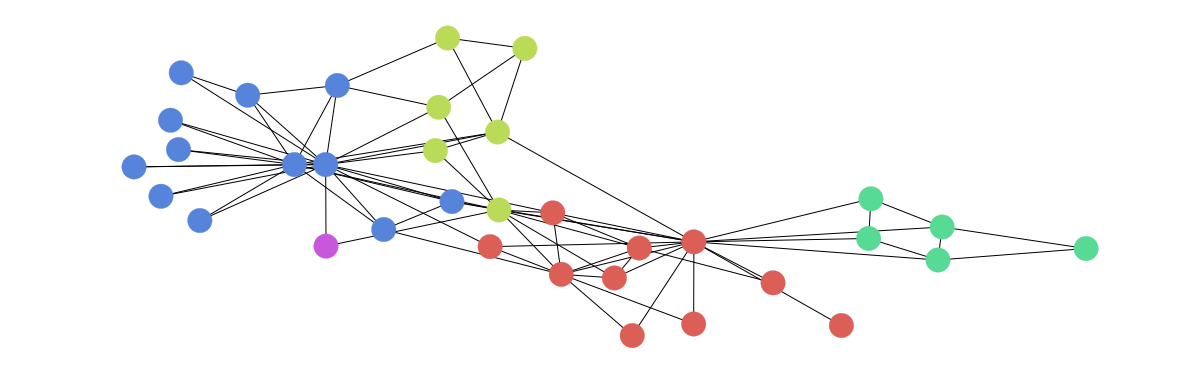

In [56]:
color_sns = sns.color_palette('hls', max(best_partition.values()) + 1 )
colors_nodes = [color_sns[best_partition[node]] for node in G.nodes()()]
plt.figure(figsize=(16,5))
nx.draw(G,pos=pos,node_color=colors_nodes, node_size=600)

## Greedy Modularity Optimization

In [58]:
G.edges(data=True)

EdgeDataView([(0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 4, {}), (0, 5, {}), (0, 6, {}), (0, 7, {}), (0, 8, {}), (0, 10, {}), (0, 11, {}), (0, 12, {}), (0, 13, {}), (0, 17, {}), (0, 19, {}), (0, 21, {}), (0, 31, {}), (1, 2, {}), (1, 3, {}), (1, 7, {}), (1, 13, {}), (1, 17, {}), (1, 19, {}), (1, 21, {}), (1, 30, {}), (2, 3, {}), (2, 7, {}), (2, 8, {}), (2, 9, {}), (2, 13, {}), (2, 27, {}), (2, 28, {}), (2, 32, {}), (3, 7, {}), (3, 12, {}), (3, 13, {}), (4, 6, {}), (4, 10, {}), (5, 6, {}), (5, 10, {}), (5, 16, {}), (6, 16, {}), (8, 30, {}), (8, 32, {}), (8, 33, {}), (9, 33, {}), (13, 33, {}), (14, 32, {}), (14, 33, {}), (15, 32, {}), (15, 33, {}), (18, 32, {}), (18, 33, {}), (19, 33, {}), (20, 32, {}), (20, 33, {}), (22, 32, {}), (22, 33, {}), (23, 25, {}), (23, 27, {}), (23, 29, {}), (23, 32, {}), (23, 33, {}), (24, 25, {}), (24, 27, {}), (24, 31, {}), (25, 31, {}), (26, 29, {}), (26, 33, {}), (27, 33, {}), (28, 31, {}), (28, 33, {}), (29, 32, {}), (29, 33, {}), (30, 32, {}), (30, 33, {}),

In [4]:
def get_modularity(G,partition):
    E_c = defaultdict(float)
    k_c = defaultdict(float)
    
    # M = float(G.number_of_edges()) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< modified
    M = 0.0
    for source_node, target_node, w in G.edges(data = True):
        M += w['weight'] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< new line
        if partition[source_node] ==  partition[target_node]:
            E_c[partition[source_node]] += w['weight']
    
    degrees = G.degree(weight='weight') # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< modified
    for node in G.nodes():
        k_c[partition[node]] += degrees[node]
        
    Q = sum( [ (E_c[c]/M) - (k_c[c]/(2.0*M))**2   for c in k_c.keys()     ]   )
    return Q

In [61]:
from random import shuffle

In [62]:
def local_optimization_step(H,Q_max, verbose=False):
    nodes = list(H.nodes())
    shuffle(nodes)
    
    something_changed = True
    iteration = 0
    
    while something_changed:
        iteration += 1
        if verbose:
            print('Iteration: %d' % iteration)
        something_changed = False 
        
        for node_i in nodes:
            neighs = list(H.neighbors(node_i))
            shuffle(neighs)
            
            diffQ = 0
            new_c = ''
            
            current_partition = nx.get_node_attributes(H,'community')
            
            for node_j in neighs:
                partition = current_partition.copy()
                partition[node_i] = H.node[node_j]['community']
                
                Q_current = get_modularity(H,partition)
                if Q_current-Q_max > diffQ:
                    new_c = H.node[node_j]['community']
                    diffQ = Q_current - Q_max
                
            if new_c:
                H.node[node_i]['community'] = new_c
                current_partition = nx.get_node_attributes(H,'community')
                Q_max = get_modularity(H,current_partition)
                something_changed = True
        
        shuffle(nodes)
        
    return Q_max

In [63]:
def network_aggregation_step(H):
    edges = defaultdict(float)
    for source_node, target_node, w in H.edges(data=True):
        c1 = H.node[source_node]['community']
        c2 = H.node[target_node]['community']
        edge = (c1,c2) if c1 > c2 else (c2,c1)
        edges[edge] += w['weight']
        
    H = nx.Graph()
    H.add_edges_from(edges.keys())
    nx.set_edge_attributes(H,values=edges, name='weight')
    for node in H.node():
        H.node[node]['community'] = node
    
    return H

In [5]:
def reindex_communities(partition):
    new_index = dict(  (community,c) for c, community in enumerate(set(partition.values()))  )
    partition = dict( (node, new_index[community]) for node, community in partition.items()  )
    return partition


In [60]:
{i:'aa' for i in range(10)}

{0: 'aa',
 1: 'aa',
 2: 'aa',
 3: 'aa',
 4: 'aa',
 5: 'aa',
 6: 'aa',
 7: 'aa',
 8: 'aa',
 9: 'aa'}

In [65]:
def louvain_method(G, init=None):
    H = G.copy()
    # init step
    #if init:
    #    best_partition = init.copy()
    #else:
    
    best_partition = {node:c for c, node in enumerate(H.nodes())}
    nx.set_node_attributes(H, values=best_partition, name='community')
    
    # mapping
    aggregate_to_original = {node:[node] for node in H.nodes() }
    
    # init edge weights
    weights = {(node_i,node_j):1.0 for node_i,node_j in H.edges()}
    nx.set_edge_attributes(H,values=weights, name='weight')
    
    Q_max = get_modularity(H,best_partition)
    
    N = len(H)
    N_prev = -1
    
    while N != N_prev:
        # 1) Local modularity opt
        Q_max = local_optimization_step(H,Q_max)
        best_partition_aggregate = nx.get_node_attributes(H,'community')

        # Update memberships
        aggregate_to_original_old = aggregate_to_original.copy()
        aggregate_to_original = defaultdict(list)
        for old_community, new_community in best_partition_aggregate.items():
            for node in aggregate_to_original_old[old_community]:
                aggregate_to_original[new_community].append(node)
                best_partition[node] = new_community
        
        # 2) net aggregation
        H = network_aggregation_step(H)
        
        N_prev = N
        N = H.number_of_nodes()
    
    best_partition = reindex_communities(best_partition)
    return best_partition

In [69]:
G = nx.karate_club_graph()
for source_node, target_node in G.edges():
    G[source_node][target_node]['weight'] = 1.0

In [72]:
best_partition = louvain_method(G)

In [73]:
get_modularity(G,best_partition)

0.4188034188034188

In [74]:
colors_sns = sns.color_palette("hls", len(set(best_partition.values()))+1)
colors_nodes = [colors_sns[best_partition[node]] for node in G.nodes()]

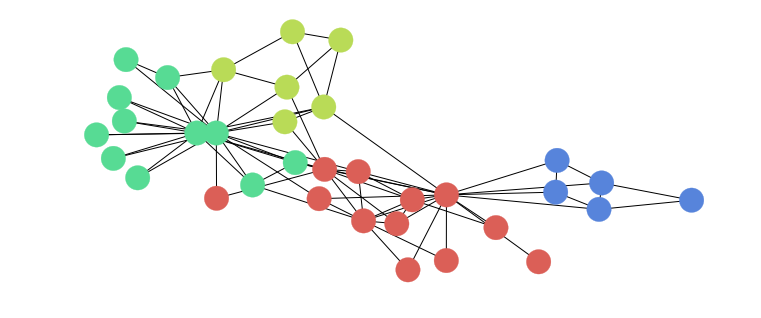

In [75]:
plt.figure(figsize=(10,4))
nx.draw(G, pos=pos, node_color=colors_nodes, node_size=600)

## Spectral Optimization

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
from random import shuffle

In [7]:
G = nx.karate_club_graph()

In [9]:
nodes = list(G.nodes())
shuffle(nodes)

In [35]:
A = nx.adj_matrix(G, nodelist=nodes)#.todense()

In [36]:
nx.adj_matrix(G, nodelist=nodes)

<34x34 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

In [37]:
k_i = A.sum(axis=1)
M = G.number_of_edges()
P = k_i.dot(k_i.T)*0.5/M

In [42]:
B = (A-P)

In [18]:
B.sum()

-1.7763568394002505e-15

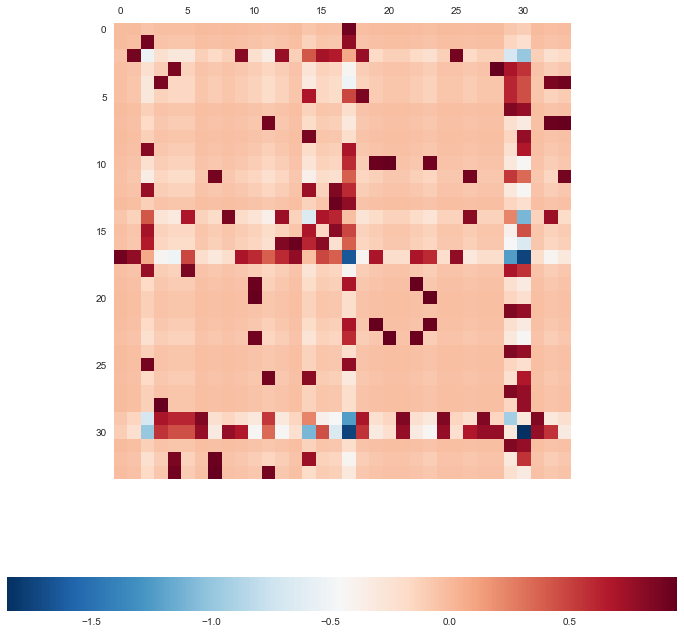

In [20]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(B, cmap = plt.cm.RdBu_r)
cbar = fig.colorbar(cax,orientation='horizontal')
ax.grid(False)

In [43]:
from scipy import sparse

In [ ]:
sparse.linalg.eigsh

In [26]:
Lambda, u = np.linalg.eigh(B)

In [27]:
Lambda

array([ -5.59249634e+00,  -3.45111371e+00,  -3.12663799e+00,
        -2.43920051e+00,  -2.09107775e+00,  -2.00000000e+00,
        -1.68805729e+00,  -1.46632948e+00,  -1.19260232e+00,
        -1.07838380e+00,  -7.92900927e-01,  -4.28208059e-01,
        -3.52166251e-16,  -1.41298900e-16,  -9.36161811e-17,
        -1.68547427e-17,   2.14839174e-17,   8.16308472e-17,
         2.06965305e-16,   2.67825838e-16,   3.98742357e-16,
         6.67771176e-16,   9.02844399e-16,   3.00015828e-01,
         4.19733784e-01,   6.16764429e-01,   8.38170794e-01,
         1.03148518e+00,   1.08328648e+00,   1.45942182e+00,
         1.48883282e+00,   2.32020502e+00,   3.04278102e+00,
         4.97708023e+00])

In [28]:
u.shape

(34, 34)

In [29]:
u_max = u[:, np.argmax(Lambda)]

In [30]:
u_max

array([-0.07784279, -0.13197981, -0.26955742,  0.20629456,  0.21674712,
        0.05447571,  0.13943288,  0.0563305 ,  0.04785238, -0.05764888,
       -0.14573804,  0.10185678, -0.20935954, -0.12874396, -0.13189899,
       -0.13502861, -0.25345236, -0.38754293,  0.09626391, -0.13400323,
       -0.05851821,  0.13943288, -0.13400323, -0.14573804,  0.13943288,
       -0.13197981,  0.06834027,  0.13943288,  0.11580257,  0.32390453,
        0.36983786,  0.13943288,  0.10276487,  0.07540039])

In [31]:
communities = np.sign(u_max) # this is s

In [32]:
communities

array([-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

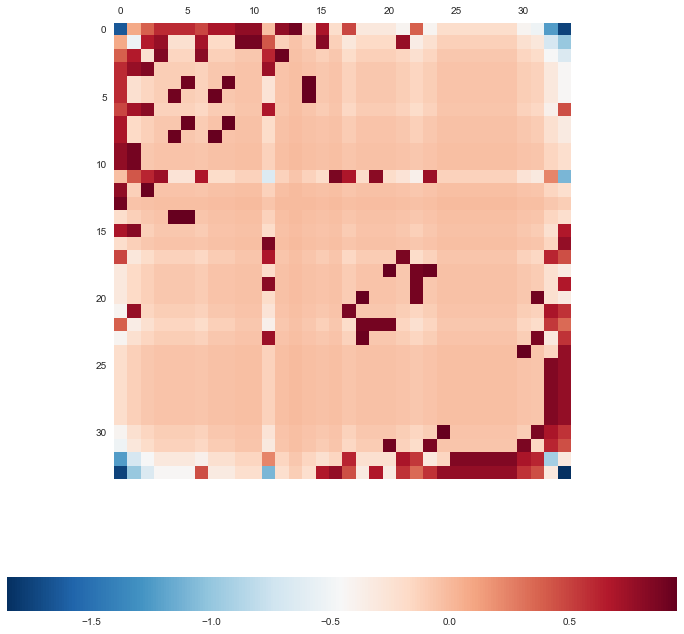

In [33]:
B_sorted = B[:, np.argsort(u_max)]
B_sorted = B_sorted[np.argsort(u_max),:]
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(B_sorted, cmap = plt.cm.RdBu_r)
cbar = fig.colorbar(cax,orientation='horizontal')
ax.grid(False)

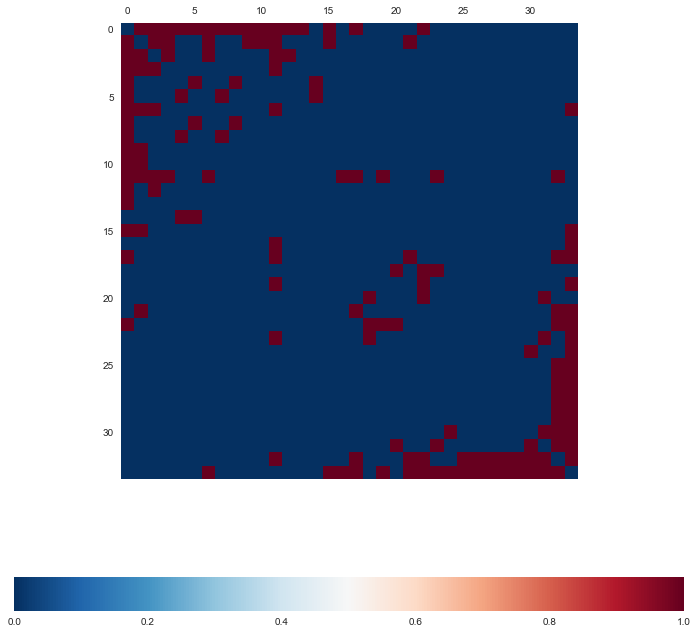

In [34]:
A_sorted = A[:, np.argsort(u_max)]
A_sorted = A_sorted[np.argsort(u_max),:]
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.matshow(A_sorted, cmap = plt.cm.RdBu_r)
cbar = fig.colorbar(cax,orientation='horizontal')
ax.grid(False)

In [44]:
partition = dict( (node, communities[k]) for k, node in enumerate(nodes))
partition = reindex_communities(partition)

In [45]:
for source_node, target_node in G.edges():
    G[source_node][target_node]['weight'] = 1.0

In [47]:
from collections import defaultdict
print(get_modularity(G,partition))

0.37146614069691


In [48]:
colors_sns = sns.color_palette("hls", len(set(partition.values()))+1)
colors_nodes = [colors_sns[partition[node]] for node in G.nodes()]
pos = nx.spring_layout(G,iterations = 150)

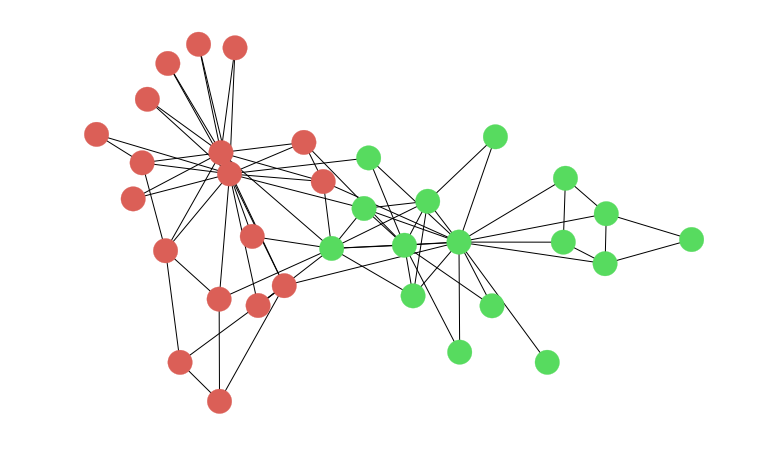

In [49]:
plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color=colors_nodes, node_size=600)

In [50]:
ideal_partition = reindex_communities(nx.get_node_attributes(G,'club'))

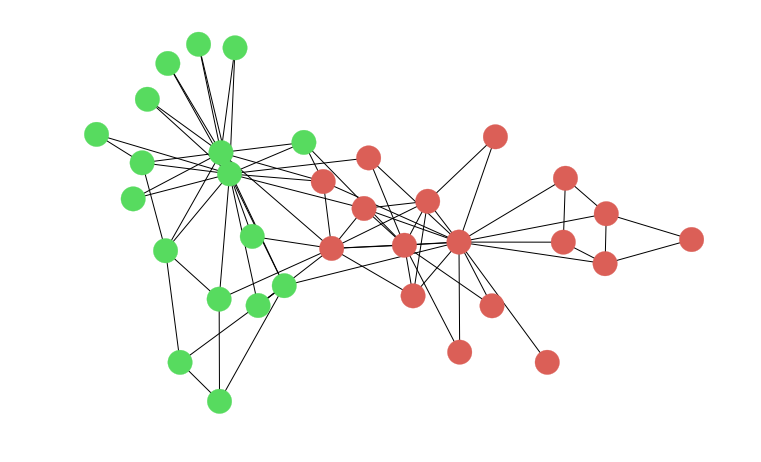

In [51]:
colors_sns = sns.color_palette("hls", len(set(ideal_partition.values()))+1)
colors_nodes = [colors_sns[ideal_partition[node]] for node in G.nodes()]
plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color=colors_nodes, node_size=600)

In [54]:
# Load the data
G = nx.karate_club_graph()

In [55]:
A = nx.adjacency_matrix(G)
degrees = np.array(A.sum(axis=0)).flatten()

In [57]:
A

<34x34 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

In [56]:
degrees

array([16,  9, 10,  6,  3,  4,  4,  4,  5,  2,  3,  1,  2,  5,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  5,  3,  3,  2,  4,  3,  4,  4,  6, 12, 17], dtype=int64)

In [58]:
from scipy.sparse import diags

In [59]:
diags?

In [60]:
D = diags(degrees, offsets=0)

In [61]:
D

<34x34 sparse matrix of type '<class 'numpy.float64'>'
	with 34 stored elements (1 diagonals) in DIAgonal format>

In [62]:
L = D - A

In [63]:
L

<34x34 sparse matrix of type '<class 'numpy.float64'>'
	with 190 stored elements in Compressed Sparse Row format>

In [65]:
N = A.shape[0]

In [66]:
N

34

In [67]:
from scipy.sparse import linalg as slinalg

In [68]:
Lambda, v = slinalg.eigsh(L, k = 2, which='SM')

In [69]:
slinalg.eigsh?

In [70]:
n1 = 15
n2 = N - n1

In [72]:
Lambda

array([ -4.14058418e-15,   4.68525227e-01])

In [71]:
v

array([[-0.17149859, -0.11213743],
       [-0.17149859, -0.04128789],
       [-0.17149859,  0.02321896],
       [-0.17149859, -0.05549978],
       [-0.17149859, -0.28460453],
       [-0.17149859, -0.32372722],
       [-0.17149859, -0.32372722],
       [-0.17149859, -0.052586  ],
       [-0.17149859,  0.05160128],
       [-0.17149859,  0.09280089],
       [-0.17149859, -0.28460453],
       [-0.17149859, -0.21099295],
       [-0.17149859, -0.1094613 ],
       [-0.17149859, -0.01474197],
       [-0.17149859,  0.16275078],
       [-0.17149859,  0.16275078],
       [-0.17149859, -0.42276533],
       [-0.17149859, -0.10018142],
       [-0.17149859,  0.16275078],
       [-0.17149859, -0.01363713],
       [-0.17149859,  0.16275078],
       [-0.17149859, -0.10018142],
       [-0.17149859,  0.16275078],
       [-0.17149859,  0.15569457],
       [-0.17149859,  0.15302558],
       [-0.17149859,  0.16096292],
       [-0.17149859,  0.18710956],
       [-0.17149859,  0.12766405],
       [-0.17149859,

In [73]:
v2 = v[:,1]

In [74]:
# largest first
s1_b = np.argsort(v2)[n2:]
s2_b = np.argsort(v2)[:n2]


In [75]:
s1_b

array([28, 31, 33, 27, 32, 24, 23, 25, 20, 22, 14, 18, 15, 29, 26])

In [76]:
s2_b

array([16,  6,  5, 10,  4, 11,  0, 12, 17, 21,  3,  7,  1, 13, 19,  2,  8,
       30,  9])

In [77]:
R_b = A[s1_b,:]
R_b = R_b[:,s2_b]
print(R_b.shape)

cut_size_b = R_b.sum()
print('Cut size: %d' % cut_size_b)

(15, 19)
Cut size: 11


In [78]:
# smallest first
s1_a = np.argsort(v2)[:n1]
s2_a = np.argsort(v2)[n1:]

R_a = A[s1_a,:]
R_a = R_a[:,s2_a]
print(R_a.shape)

cut_size_a = R_a.sum()

print('Cut size: %d' % cut_size_a)

(15, 19)
Cut size: 10


In [79]:
if cut_size_a < cut_size_b:
    best_partition = dict([(i,0) if i in s1_a else (i,1) for i in range(N)])
else:
    best_partition = dict([(i,0) if i in s1_b else (i,1) for i in range(N)])

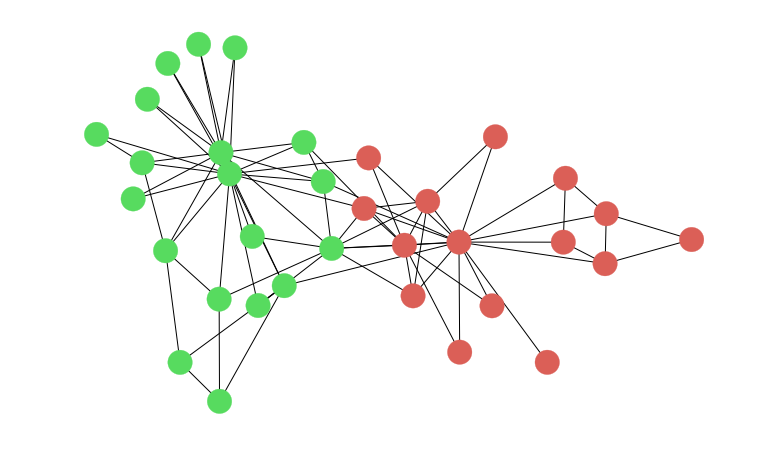

In [80]:
colors_sns = sns.color_palette("hls", len(set(best_partition.values()))+1)
colors_nodes = [colors_sns[best_partition[node]] for node in G.nodes()]
plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color=colors_nodes, node_size=600)

In [83]:
# Load the data
G = nx.karate_club_graph()
nodes = G.nodes()
N = len(nodes)
for source_node, target_node in G.edges():
    G[source_node][target_node]['weight'] = 1.0

In [85]:
# Create the Laplacian Matrix
A = nx.adjacency_matrix(G, nodelist=nodes)
degrees = np.array(A.sum(axis=0)).flatten()
D = diags(degrees, offsets = 0)
L = D - A

In [86]:
K = 4
w, v = slinalg.eigsh(L, k = K, which = 'SM')
V = v[:, 1:]

In [87]:
V

array([[-0.11213743, -0.06940423,  0.07181871],
       [-0.04128789, -0.09514749,  0.19454754],
       [ 0.02321896, -0.04270411,  0.09881107],
       [-0.05549978, -0.10584319,  0.21217767],
       [-0.28460453,  0.12126623, -0.03113051],
       [-0.32372722,  0.20167565, -0.09905757],
       [-0.32372722,  0.20167565, -0.09905757],
       [-0.052586  , -0.10130188,  0.20081988],
       [ 0.05160128, -0.01467707,  0.04634388],
       [ 0.09280089, -0.01311954,  0.08990031],
       [-0.28460453,  0.12126623, -0.03113051],
       [-0.21099295, -0.76476516, -0.57450041],
       [-0.1094613 , -0.16066655,  0.32457127],
       [-0.01474197, -0.06959724,  0.14379542],
       [ 0.16275078,  0.06068003, -0.06345644],
       [ 0.16275078,  0.06068003, -0.06345644],
       [-0.42276533,  0.36979183, -0.22642009],
       [-0.10018142, -0.15086075,  0.3044223 ],
       [ 0.16275078,  0.06068003, -0.06345644],
       [-0.01363713, -0.06512382,  0.13131648],
       [ 0.16275078,  0.06068003, -0.063

In [89]:
from scipy.spatial.distance import cosine as cosine_distance


In [90]:
# Let us compute the pair-wise differences using cosine distance
distances = []
for i in range(N):
    for j in range(i+1, N):
        distances.append( cosine_distance( V[i,:] , V[j,:]  ) )
distances = np.array(distances)
distances[distances<0] = 0.0

In [91]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [92]:
Z = linkage(distances, method = 'complete')

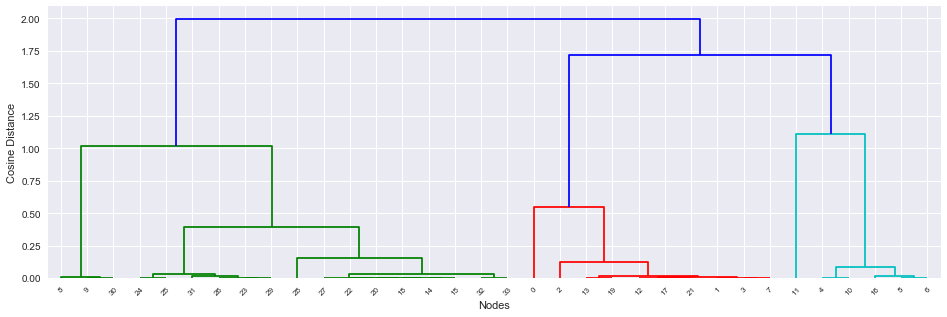

In [93]:
from matplotlib import pylab as plt
fig, ax = plt.subplots(figsize=(16,5))
d = dendrogram(Z) #,labels=nodes)
ax.set_xlabel('Nodes')
ax.set_ylabel('Cosine Distance')

In [95]:
dist_clusters = Z[:,2]

In [96]:
dist_clusters

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.51979632e-06,   2.30443894e-05,
         4.61518933e-05,   2.30751347e-04,   4.32458801e-04,
         9.24756416e-04,   2.09398386e-03,   4.26321454e-03,
         4.62492007e-03,   5.28507979e-03,   5.53181499e-03,
         6.44944446e-03,   1.33816675e-02,   2.00039110e-02,
         2.02693165e-02,   3.16970287e-02,   3.29261583e-02,
         8.54045250e-02,   1.26541973e-01,   1.55271648e-01,
         3.91327039e-01,   5.49073442e-01,   1.01911929e+00,
         1.10709179e+00,   1.71948107e+00,   1.99189080e+00])

In [97]:
fcluster(Z, t = 1, criterion = 'distance')

array([3, 3, 3, 3, 4, 4, 4, 3, 1, 1, 4, 5, 3, 3, 2, 2, 4, 3, 2, 3, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2], dtype=int32)

In [98]:
for d in sorted(set(dist_clusters)):
    cluster = fcluster(Z, t = d, criterion = 'distance')
    partition = dict( (node,c) for node, c in enumerate(cluster))
    #print cluster,
    print('Q=%1.3f, C=%d, distance=%1.4f' % (get_modularity(G, partition), len(set(cluster)),d))

Q=-0.030, C=27, distance=0.0000
Q=-0.019, C=26, distance=0.0000
Q=-0.020, C=25, distance=0.0000
Q=-0.021, C=24, distance=0.0000
Q=-0.009, C=23, distance=0.0002
Q=0.002, C=22, distance=0.0004
Q=0.021, C=21, distance=0.0009
Q=0.020, C=20, distance=0.0021
Q=0.031, C=19, distance=0.0043
Q=0.028, C=18, distance=0.0046
Q=0.024, C=17, distance=0.0053
Q=0.053, C=16, distance=0.0055
Q=0.064, C=15, distance=0.0064
Q=0.058, C=14, distance=0.0134
Q=0.082, C=13, distance=0.0200
Q=0.104, C=12, distance=0.0203
Q=0.212, C=11, distance=0.0317
Q=0.242, C=10, distance=0.0329
Q=0.263, C=9, distance=0.0854
Q=0.287, C=8, distance=0.1265
Q=0.289, C=7, distance=0.1553
Q=0.331, C=6, distance=0.3913
Q=0.389, C=5, distance=0.5491
Q=0.391, C=4, distance=1.0191
Q=0.390, C=3, distance=1.1071
Q=0.371, C=2, distance=1.7195
Q=0.000, C=1, distance=1.9919


In [99]:
# Find all partitions and get the one with the maximum modularity
partition = {}
modularities = {}
for i,d in enumerate(dist_clusters):
    cluster = fcluster(Z, t = d, criterion = 'distance')
    partition[i] = dict( (node,c) for node, c in enumerate(cluster))
    modularities[i] = get_modularity(G, partition[i])

In [101]:
modularities

{0: -0.029832347140039447,
 1: -0.029832347140039447,
 2: -0.029832347140039447,
 3: -0.029832347140039447,
 4: -0.029832347140039447,
 5: -0.029832347140039447,
 6: -0.029832347140039447,
 7: -0.01898422090729783,
 8: -0.019641683103221563,
 9: -0.020874424720578568,
 10: -0.008793556870479951,
 11: 0.0023833004602235395,
 12: 0.020627876397107163,
 13: 0.019970414201183423,
 14: 0.03131163708086785,
 15: 0.02802432610124917,
 16: 0.024079552925706762,
 17: 0.05317225509533201,
 18: 0.06352728468113085,
 19: 0.05810322156476003,
 20: 0.08242932281393822,
 21: 0.10445430637738333,
 22: 0.21211374095989483,
 23: 0.2421926364234057,
 24: 0.2629026955950033,
 25: 0.28706443129520054,
 26: 0.2892833662064431,
 27: 0.33053911900065747,
 28: 0.3893819855358317,
 29: 0.3911078238001316,
 30: 0.3897928994082841,
 31: 0.37146614069691,
 32: 0.0}

In [102]:
k_best = sorted(modularities.items(), key = lambda x:x[1], reverse = True)[0][0]
best_partition = partition[k_best]
best_partition = reindex_communities(best_partition)

In [103]:
print(get_modularity(G,best_partition))

0.3911078238001316


In [105]:
# Find the optimal K and the best partition
best_partition = {}
best_modularity = defaultdict(float)
for K in range(2,11):
    print('K=%d' % K)
    w, v = slinalg.eigsh(L,k=K,which='SM')
    V = v[:,1:]
    
    distances = []
    for i in range(N):
        for j in range(i+1,N):
            distances.append(cosine_distance(V[i,:],V[j,:]))
    distances = np.array(distances)
    distances[distances<0] = 0.0
    
    Z = linkage(distances, method='complete') 
    dist_clusters = Z[:,2]
    partitions = {}
    modularities = {}
    for i,d in enumerate(dist_clusters):
        cluster = fcluster(Z,t=d,criterion='distance')
        partitions[i] = dict( (node, c) for node,c in enumerate(cluster))
        modularities[i] = get_modularity(G,partitions[i])
        if modularities[i] > best_modularity[K]:
            best_modularity[K]= modularities[i]
            best_partition[K] = partitions[i]

K=2
K=3
K=4
K=5
K=6
K=7
K=8
K=9
K=10


In [106]:
best_modularity

defaultdict(float,
            {2: 0.35996055226824464,
             3: 0.39907955292570685,
             4: 0.3911078238001316,
             5: 0.4118178829717291,
             6: 0.39801117685733073,
             7: 0.3570841551610782,
             8: 0.34870151216305056,
             9: 0.32478632478632474,
             10: 0.3067061143984221})

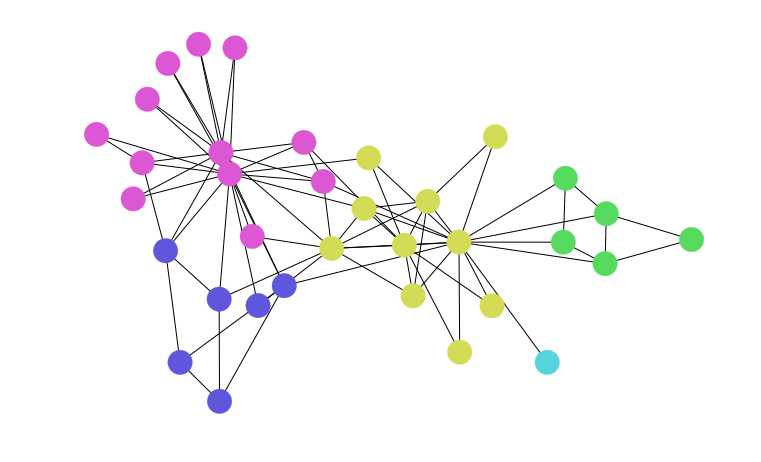

In [107]:
colors_sns = sns.color_palette("hls", len(set(best_partition[5].values()))+1)
colors_nodes = [colors_sns[best_partition[5][node]] for node in G.nodes()]
plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color=colors_nodes, node_size=600)

## References

* Fortunato, S. (2010). Community detection in graphs. Physics reports, 486(3), 75-174.
* Girvan, M., & Newman, M. E. (2002). Community structure in social and biological networks. Proceedings of the national academy of sciences, 99(12), 7821-7826.
* Radicchi, F., Castellano, C., Cecconi, F., Loreto, V., & Parisi, D. (2004). Defining and identifying communities in networks. Proceedings of the National Academy of Sciences of the United States of America, 101(9), 2658-2663.
* Newman, M. E. (2004). Fast algorithm for detecting community structure in networks. Physical review E, 69(6), 066133.
* Newman, M. E. (2006). Modularity and community structure in networks. Proceedings of the national academy of sciences, 103(23), 8577-8582.
* Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of statistical mechanics: theory and experiment, 2008(10), P10008.

## Huffman Coding

![](https://upload.wikimedia.org/wikipedia/commons/6/69/Min-heap.png)


In Python, we can easily create a (min) heap queue using **heapq**: https://docs.python.org/3.0/library/heapq.html

In [2]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np

In [9]:
symb2freq = {'A':15,'B':7, 'C':6, 'E':5, 'F':4}

In [20]:
# Step 1: create priority queue
queue = [ [c, [s, ""] ]  for s, c in symb2freq.items()]
heapify(queue)

# Step 2: create tree and update labels
while len(queue)>1:
    # Collect the two nodes
    node1 = heappop(queue)
    node2 = heappop(queue)
    
    combined_prob = node1[0] + node2[0]
    
    # update/create labels
    updated_node1 = []
    for symbol,label in node1[1:]:
        new_label = '0' + label
        updated_node1.append([symbol,new_label])
    updated_node2 = []
    for symbol,label in node2[1:]:
        new_label = '1' + label
        updated_node2.append([symbol,new_label])

    # add new node
    new_node = [combined_prob] + [node for node in updated_node1 + updated_node2]
    heappush(queue, new_node)
    
# Step 3: create codebook
codebook = {symbol:label for symbol, label in queue[0][1:]}

In [22]:
def get_huffman_codebook(symb2freq):
    # Step 1: create the priority queue using min-heap
    queue = [[wt, [sym,""]] for sym, wt in symb2freq.items()]
    heapify(queue)

    # Step 2: create the tree and update the labels
    while len(queue)>1:
        # Collect the two nodes with the lowest probability (i.e. highest priority in the queue)
        node1 = heappop(queue)
        node2 = heappop(queue)
        combined_prob = node1[0] + node2[0]
        # Update labels
        updated_node1 = []
        for symbol,label in node1[1:]:
            new_label = '0' + label
            updated_node1.append([symbol,new_label])
        updated_node2 = []
        for symbol,label in node2[1:]:
            new_label = '1' + label
            updated_node2.append([symbol,new_label])
        # Add the new node in the min-heap queue
        new_node = [combined_prob] + [node for node in updated_node1 + updated_node2]
        heappush(queue, new_node)

    # Step 3: collect the new (symbol,label) pairs in a dictionary
    codebook = {symbol:label for symbol,label in queue[0][1:]}
    
    return codebook

In [23]:
get_huffman_codebook(symb2freq)

{'A': '0', 'B': '111', 'C': '110', 'E': '101', 'F': '100'}

## Average number of questions to guess a number

In [36]:
N = 100
wt = np.random.randint(N**3, size=N)
wt = wt/wt.sum()
symb2freq = {n:wt[n] for n in range(N)}

In [37]:
B = 1000
symb2code = get_huffman_codebook(symb2freq)
values, probs = zip(*symb2freq.items())
numbers = np.random.choice(values, size=B,replace=True,p=probs)
max_length = max(map(len,symb2code.values()))
N_q = []
for num, code in list(map(lambda x:(x,symb2code[x]),numbers)):
    #print(num, code)
    n_questions = 0 
    candidates = sorted(symb2code.values())
    for i in range(max_length):
        n_questions += 1
        if code[i] == '0':
            candidates = [c for c in candidates if c[i]=='0']
        else:
            candidates = [c for c in candidates if c[i]=='1']
        if len(candidates)==1:
            break
    N_q.append(n_questions)
            
    

In [38]:
average_number_questions = np.mean(N_q)

In [39]:
print('Average number of questions asked: %1.2f' % average_number_questions)


Average number of questions asked: 6.45


In [40]:
def get_entropy(p):
    return - sum([p_i*np.log2(p_i) for p_i in p])

In [41]:
entropy = get_entropy(symb2freq.values())

In [42]:
print('Entropy: %1.2f' % entropy)


Entropy: 6.41


In [43]:
average_code_length = sum([p*len(symb2code[s]) for s,p in symb2freq.items()])/sum(symb2freq.values())

In [44]:
print('Average code length: %1.2f' % average_code_length)


Average code length: 6.43


In [18]:
queue

[[37, ['A', '0'], ['F', '100'], ['E', '101'], ['C', '110'], ['B', '111']]]

In [16]:
queue[0]

[4, ['F', '']]

In [8]:
heappop(queue)

[4, ['F', '']]

In [5]:
queue

[[15, ['A', '']],
 [7, ['B', '']],
 [6, ['C', '']],
 [5, ['E', '']],
 [4, ['F', '']]]

In [11]:
heapify(queue)

In [12]:
queue #  heap[k] <= heap[2*k+1] and heap[k] <= heap[2*k+2]

[[4, ['F', '']],
 [5, ['E', '']],
 [6, ['C', '']],
 [15, ['A', '']],
 [7, ['B', '']]]

In [14]:
while queue:
    print(heappop(queue))

[4, ['F', '']]
[5, ['E', '']]
[6, ['C', '']]
[7, ['B', '']]
[15, ['A', '']]


In [ ]:
queue[]